<a href="https://colab.research.google.com/github/YousefSoltanian/MAE598_Design_Optimization/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Inverted Double Pendulum on a Cart System

## System Description

Consider a double pendulum mounted on a cart, where the cart has mass $m$ and the pendulum has two rods with lengths $l_1$ and $l_2$. Point masses $m_1$ and $m_2$ are attached to the rods. The rods are assumed to be massless.

## Generalized Coordinates

Let $\theta_1$ and $\theta_2$ be the deviations of the rods from the upright position, and $q$ be the horizontal position of the cart. The system has three generalized coordinates: $q$, $\theta_1$, and $\theta_2$.

## Derivatives

The derivatives with respect to time are denoted as $\dot{q}$, $\dot{\theta}_1$, and $\dot{\theta}_2$.

## Control Input

The control input is denoted as $u(t)$, representing the force applied to the cart.

## External Disturbances

External disturbances $w_1$, $w_2$, $w_3$ act as forces on $q$, $\theta_1$, and $\theta_2$.

## Damping and Friction

Damping coefficients $d_1$, $d_2$, $d_3$ model friction and damping. The friction/damping force of the cart is $-d_1\dot{q}$, and the friction/damping forces in the joints are $-d_2\dot{\theta}_1$ and $-d_3\dot{\theta}_2$.

# System Dynamics

## Kinetic Energy K and Potential Energy P

The kinetic energy of the system is given by:
\begin{equation}
K = \frac{1}{2} \left[ m\dot{q}^2 + m_1(\dot{q} + l_1\dot{\theta}_1\cos\theta_1)^2 + m_2(\dot{q} + l_1\dot{\theta}_1\cos\theta_1 + l_2\dot{\theta}_2\cos\theta_2)^2 \right]
\end{equation}

The potential energy of the system is given by:

\begin{equation}
P = g \left[ m_1l_1\cos\theta_1 + m_2(l_1\cos\theta_1 + l_2\cos\theta_2) \right]
\end{equation}
## Lagrangian Mechanics

The Lagrangian $L$ is defined as the difference between kinetic and potential energy:

\begin{equation}
 L = K - P
\end{equation}

The equations of motion for the cart are derived using the principle of Lagrangian mechanics, resulting in the matrix equation:

\begin{equation}
 M(y)\ddot{y} = f(y, \dot{y}, u, \dot{w})
\end{equation}

where $M(y)$ is an invertible matrix.

## State-Space Equation

Defining the state vector $x = [q, \dot{q}, \theta_1, \dot{\theta}_1, \theta_2, \dot{\theta}_2]$, the state-space equation is given by:

\begin{aligned}\begin{bmatrix} m + m_1 + m_2 & l_1(m_1 + m_2) \cos \theta_1 & m_2l_2 \cos \theta_2 \\ l_1(m_1 + m_2) \cos \theta_1 & l_1^2 (m_1 + m_2) & l_1 l_2 m_2 \cos (\theta_1 - \theta_2) \\ l_2 m_2 \cos \theta_2 & l_1 l_2 m_2 \cos (\theta_1 - \theta_2) & l_2^2 m_2 \end{bmatrix}\begin{bmatrix} \ddot{q} \\ \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix}\end{aligned} =
\begin{aligned}
\begin{bmatrix}
l_1(m_1 + m_2)\dot{\theta}_1^2\sin \theta_1 + m_2l_2\dot{\theta}_2^2\sin \theta_2 \\
-l_1l_2m_2\dot{\theta}_2^2\sin(\theta_1 - \theta_2) + gl_1(m_1 + m_2)\sin \theta_1 \\
l_1l_2m_2\dot{\theta}_1^2\sin(\theta_1 - \theta_2) + g l_2 m_2 \sin \theta_2
\end{bmatrix}
-\begin{bmatrix} d_1 \dot{q} \\ d_2 \dot{\theta}_1 \\ d_3 \dot{\theta}_2 \end{bmatrix} + \begin{bmatrix} u \\ 0 \\ 0 \end{bmatrix} + \begin{bmatrix} w_1 \\ w_2 \\ w_3 \end{bmatrix}
\end{aligned}

This system of equations describes the motion of an inverted double pendulum on a cart subject to control input and external disturbances.


In [ ]:
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)



## Modeling the Dynamic

We have modeled the inverted double pendulum dynamic using the function below, it takes the current states and the action and gives the next states. we have used torch.linalg.solve method for solving the equation and then we have used a simple update rule.

In [ ]:
from typing_extensions import Required
import torch
import torch.nn as nn

device = "cpu" if not torch.cuda.is_available() else "cuda:0"
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 15e-4
max_grad_norm = 1.0

class IDPDynamics(nn.Module):
    def __init__(self, m=1.0, m1=1.0, m2=1.0, l1=1.0, l2=1.0, d1=0.1, d2=0.1, d3=0.1):
        super(IDPDynamics, self).__init__()
        self.m = m
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.g = 9.8  # gravitational acceleration

    def forward(self, state, action):
        """
        state[0] = q
        state[1] = q_dot
        state[2] = theta1
        state[3] = theta1_dot
        state[4] = theta2
        state[5] = theta2_dot

        action[0] = u (control input)

        External disturbances w1, w2, w3 are added as small random noises.
        """

        # Unpack state and action
        q, q_dot, theta1, theta1_dot, theta2, theta2_dot = state.squeeze()
        u = action.squeeze()

        # External disturbances (small random noises)
        w1 = torch.randn(1) * 0.0001
        w2 = torch.randn(1) * 0.0001
        w3 = torch.randn(1) * 0.0001

        # Equations of motion
        M = torch.tensor([
            [self.m + self.m1 + self.m2, self.l1 * (self.m1 + self.m2) * torch.cos(theta1), self.m2 * self.l2 * torch.cos(theta2)],
            [self.l1 * (self.m1 + self.m2) * torch.cos(theta1), self.l1**2 * (self.m1 + self.m2), self.l1 * self.l2 * self.m2 * torch.cos(theta1 - theta2)],
            [self.m2 * self.l2 * torch.cos(theta2), self.l1 * self.l2 * self.m2 * torch.cos(theta1 - theta2), self.l2**2 * self.m2]
        ], device=device,requires_grad=True)

        # damping matrices
        D = torch.tensor([
            [self.d1, 0, 0],
            [0, self.d2, 0],
            [0, 0, self.d3]
        ], device=device)

        F = torch.tensor([
        [self.l1 * (self.m1 + self.m2) * theta1_dot**2 * torch.sin(theta1) + self.m2 * self.l2 * theta2_dot**2 * torch.sin(theta2)],
        [-self.l1 * self.l2 * self.m2 * theta2_dot**2 * torch.sin(theta1 - theta2) + self.g * self.l1 * (self.m1 + self.m2) * torch.sin(theta1)],
        [self.l1 * self.l2 * self.m2 * theta1_dot**2 * torch.sin(theta1 - theta2) + self.g * self.l2 * self.m2 * torch.sin(theta2)]
        ],device=device,requires_grad=True)

        state_dot = torch.tensor([
            [q_dot],
            [theta1_dot],
            [theta2_dot]
        ],device=device)

        input = torch.cat([u.view(1), torch.zeros(2, device=device)], dim=0).view(-1, 1)

        state_double_dot = F - D@state_dot + input + torch.tensor([[w1],[w2],[w3]],device=device)

        # Solve for state_double_dot using torch.linalg.solve
        q_double_dot, theta1_double_dot, theta2_double_dot = torch.linalg.solve(M, state_double_dot)
        dt = torch.tensor(0.01, device=device)
        delta_state = torch.cat([q_dot.unsqueeze(0), q_double_dot, theta1_dot.unsqueeze(0), theta1_double_dot, theta2_dot.unsqueeze(0), theta2_double_dot], dim=0) * dt
         #Update state
        next_state = state + delta_state

        return next_state


# Example usage:
dynamics_model = IDPDynamics()

# Example initial state and action
initial_state = torch.tensor([[0.0, 0.0, 0.1, 0.0, 0.1, 0.0]],device=device)
action = torch.tensor([[1.0]],requires_grad=True,device=device)

# Forward pass
next_state = dynamics_model(initial_state, action)
print(action)
print("Next State:", next_state)
B = 3*action
print(B)

tensor([[1.]], device='cuda:0', requires_grad=True)
Next State: tensor([[ 0.0000e+00, -9.2855e-03,  1.0000e-01,  1.9024e-02,  1.0000e-01,
         -1.9159e-06]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[3.]], device='cuda:0', grad_fn=<MulBackward0>)


## Probabilistic Controller

Although we have only 1 action in this problem, we have used a probabilistic actor to model the action. meaning that the outputs of the network are 2 numbers, one of them representing a mean value and the other one representing a standard deviation. the final action from the controller comes from the distribution made by that mean value and that standard deviation. we want that final action to always be in the range of $(-1,1)$, for this purpose we have used a $tanh$ distribution. Also, to ensure that the mean value is withen the range $(-1,1)$ we have used a $tanh$ activation for the mean value and a $softplus$ activation for the standard devitation to ensure that it is always positive.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, TransformedDistribution, TanhTransform

class controller(nn.Module):
    def __init__(self, dim_input=6, dim_hidden=16, dim_output=1):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden:
        """
        super(controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden, device=device),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, device=device),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden, device=device),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output, device=device)
        )

    def forward(self, state):
        output = self.network(state)

        # Assuming output[0][0] and output[0][1] are the relevant parts of your network output
        #mean = torch.tanh(output[0][0])
        #std = 0.001 * F.softplus(output[0][1]) + 1e-5  # Add a small constant for numerical stability

        #base_distribution = Normal(mean, std)

        # Sample from the distribution
        #action = base_distribution.sample()

        # Ensure the action tensor has requires_grad=True
        #action.requires_grad_(True)

        return torch.tanh(output)
#test


controller0 = controller()
IDP = IDPDynamics()
# test
input_data = torch.randn(1, 6,device=device)  # Replace with your actual input data
action = controller0(input_data)
#next_state = IDP(input_data,action)
#print("action", action)
#print("next state", next_state)
#action = controller0(next_state)
print(action)
#print(next_state)


tensor([[0.1259]], device='cuda:0', grad_fn=<TanhBackward0>)


In [ ]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T=500):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1,0),device=device)
        self.u_trajectory = torch.empty((1,0),device=device)
        self.cost = torch.tensor(0.0, requires_grad=True, device=device);
        self.gamma = 0.99;

    def forward(self):
        self.action_trajectory = []
        self.state_trajectory = []
        self.state = self.initialize_state()
        self.cost = torch.tensor(0.0, requires_grad=True, device=device);
        for _ in range(self.T):
            action = self.controller(self.state)
            self.state = self.dynamics(self.state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(self.state)
        self.error()
        return self.cost

    def error(self):
        self.cost = self.cost + 1*self.gamma*((self.state[0][0])**2 + 10*(self.state[0][1])**2 + 10*(self.state[0][2])**2 + 10*(self.state[0][4])**2 )
        #self.cost = (self.state[0][0])**2
    @staticmethod
    def initialize_state():
        #return torch.tensor([[-5, 0, 0, 0, 0, 0]], dtype=torch.float32, requires_grad=T, device=device)
        return torch.tensor([[-5,0,0,0,0,0]],requires_grad=False, device=device).float()



# test
input_data = torch.randn(1, 6,device=device)
env = Simulation(controller(),IDPDynamics())
cost = env()

print("cost:", cost)
print(env.state)

cost: tensor(1209.3354, device='cuda:0', grad_fn=<AddBackward0>)
tensor([[-5.0970,  0.6314, 10.8632, -3.7471,  1.0716, -7.2100]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
import torch.nn.utils as nn_utils
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects

    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.004) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation()  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            nn_utils.clip_grad_norm_(self.parameters, max_grad_norm)  # Apply gradient clipping
            return loss

        self.optimizer.step(closure)
        first_param = list(self.simulation.controller.parameters())[2].data
        print(first_param[0])
        return closure()

    # Define training method for the model


    def train(self, epochs):
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()

        plt.plot(list(range(epochs)), l)

        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)

    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].cpu().detach().numpy() for i in range(self.simulation.T)])
        q = data[:, 0]
        q_dot = data[:, 1]
        theta1 = data[:, 2]
        theta1_dot = data[:, 3]
        theta2 = data[:, 4]
        theta2_dot = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i].item() for i in range(self.simulation.T)])
        thrust = action_data[:]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(frame, q, c = 'b')
        ax[0].set_xlabel("q")
        ax[0].set_ylabel("Time")
        ax[0].set(title=f'Displacement of the cart at frame {self.epoch}')

        ax[1].plot(frame, theta1, c = 'c', label = "Theta1")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Theta1")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Theta1 {self.epoch}')

        ax[2].plot(frame, theta2, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta2")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta2 {self.epoch}')

        ax[3].plot(frame, thrust, c = 'y', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("control signal")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'control signal {self.epoch}')
        plt.show()

    def animation(self, epochs):
              # Size
        length = 0.10          # m
        width = 0.02          # m

        #
        v_exhaust = 1
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i].item() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust line

        plt.tight_layout()

        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 4]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            flame_length = (thrust_mag) * (0.4/v_exhaust)
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.sin(rocket_theta)]
            flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(rocket_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("rocket_landing1.gif", writer=writer)




tensor([-0.1411,  0.0099,  0.0346, -0.2002,  0.1918, -0.0130,  0.0130,  0.1589,
         0.0047, -0.0031,  0.1199,  0.2335,  0.2285, -0.1555,  0.0327,  0.1413],
       device='cuda:0')
[1] loss: 1242.289


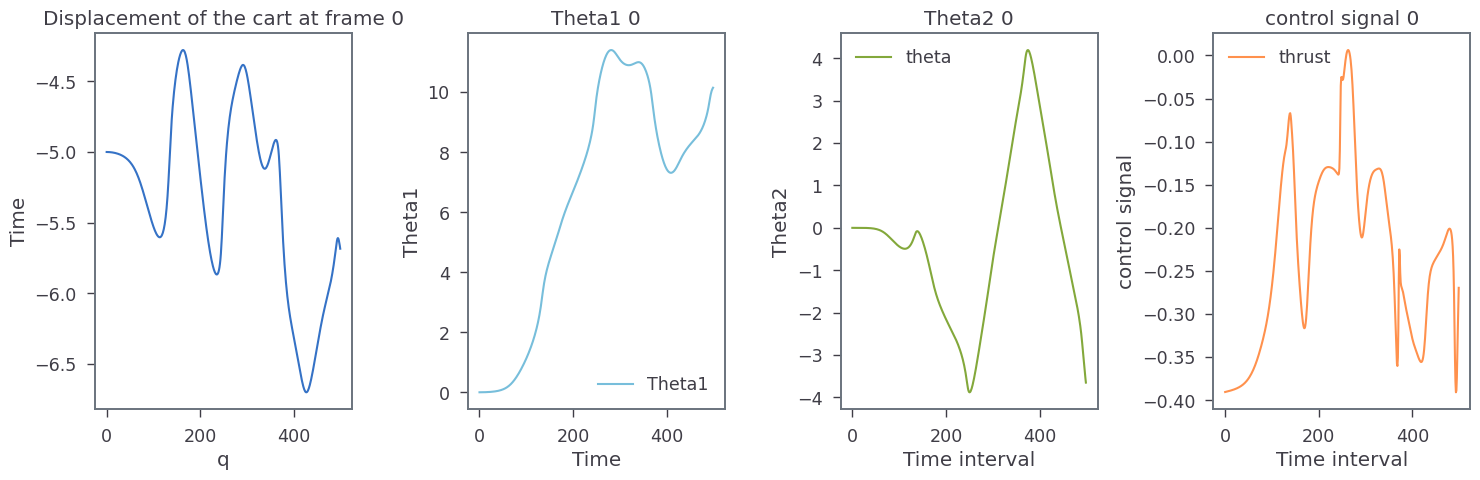

tensor([ 0.0136, -0.1188,  0.0031, -0.0846, -0.0728, -0.1923,  0.3463, -0.0623,
        -0.1651, -0.2167, -0.1452,  0.4189,  0.1815, -0.2708, -0.0044,  0.1398],
       device='cuda:0')
[2] loss: 1235.833


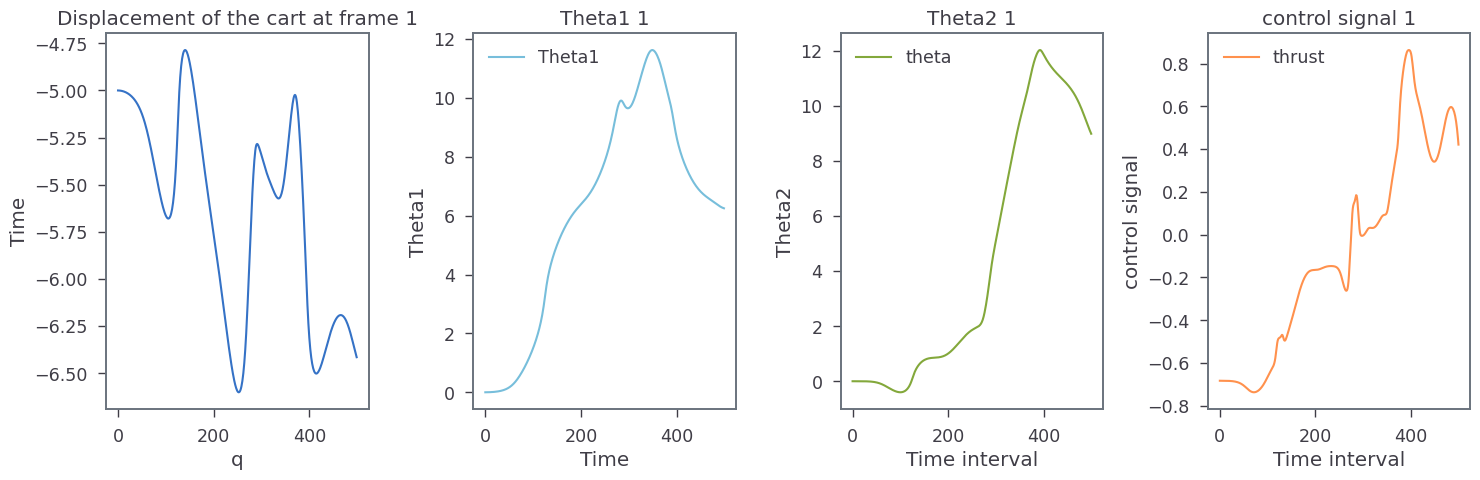

tensor([ 0.0082, -0.1142,  0.0042, -0.0887, -0.0635, -0.1861,  0.3345, -0.0544,
        -0.1590, -0.2092, -0.1357,  0.4124,  0.1832, -0.2667, -0.0030,  0.1398],
       device='cuda:0')
[3] loss: 1241.000


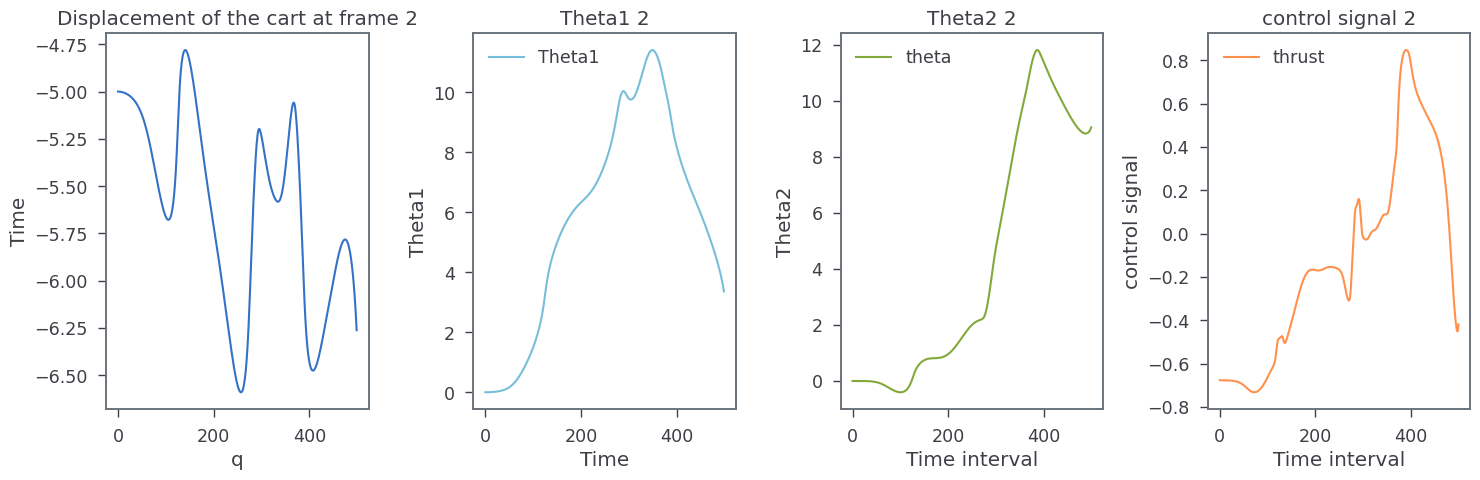

tensor([-0.0010, -0.1066,  0.0060, -0.0955, -0.0483, -0.1761,  0.3151, -0.0415,
        -0.1492, -0.1965, -0.1194,  0.4019,  0.1858, -0.2598, -0.0009,  0.1399],
       device='cuda:0')
[4] loss: 1566.444


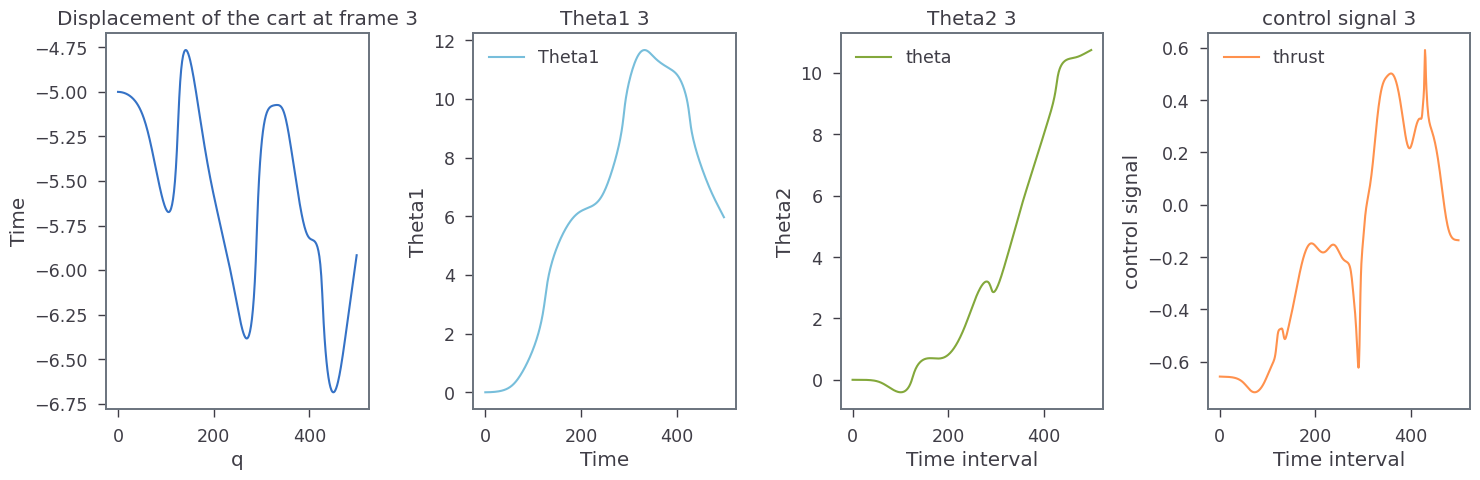

tensor([-0.0011, -0.1064,  0.0060, -0.0956, -0.0480, -0.1759,  0.3147, -0.0413,
        -0.1490, -0.1963, -0.1190,  0.4017,  0.1858, -0.2597, -0.0008,  0.1398],
       device='cuda:0')
[5] loss: 2751.002


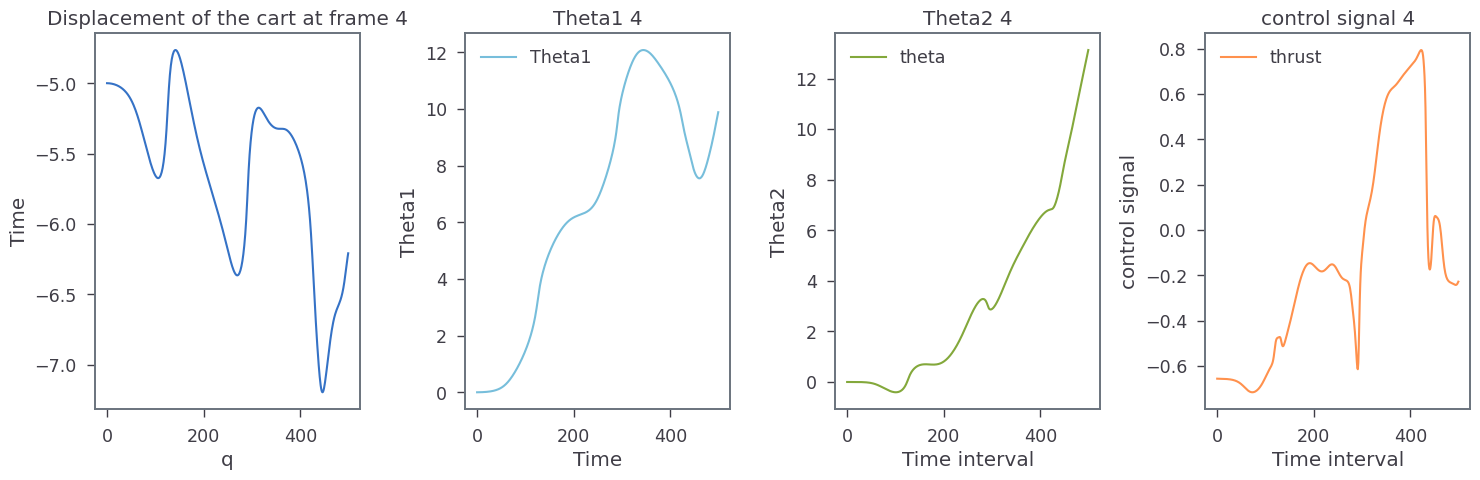

tensor([-0.0011, -0.1064,  0.0060, -0.0956, -0.0480, -0.1759,  0.3147, -0.0413,
        -0.1490, -0.1963, -0.1190,  0.4017,  0.1858, -0.2597, -0.0008,  0.1398],
       device='cuda:0')
[6] loss: 2817.931


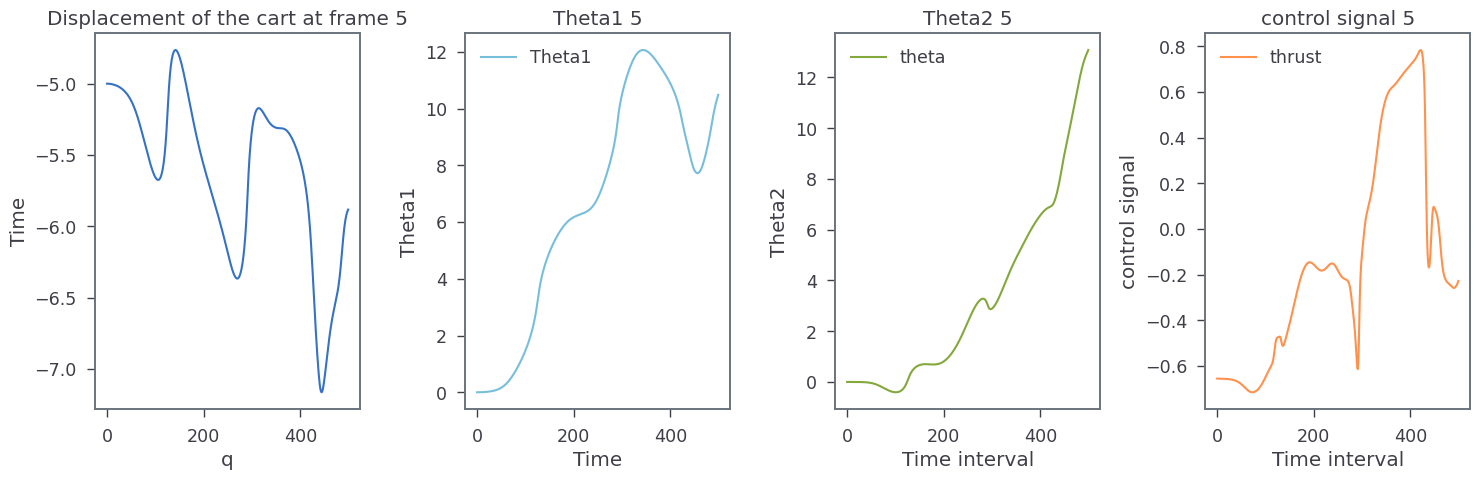

tensor([-0.0011, -0.1064,  0.0060, -0.0956, -0.0480, -0.1759,  0.3147, -0.0413,
        -0.1490, -0.1963, -0.1190,  0.4017,  0.1858, -0.2597, -0.0008,  0.1398],
       device='cuda:0')
[7] loss: 2679.072


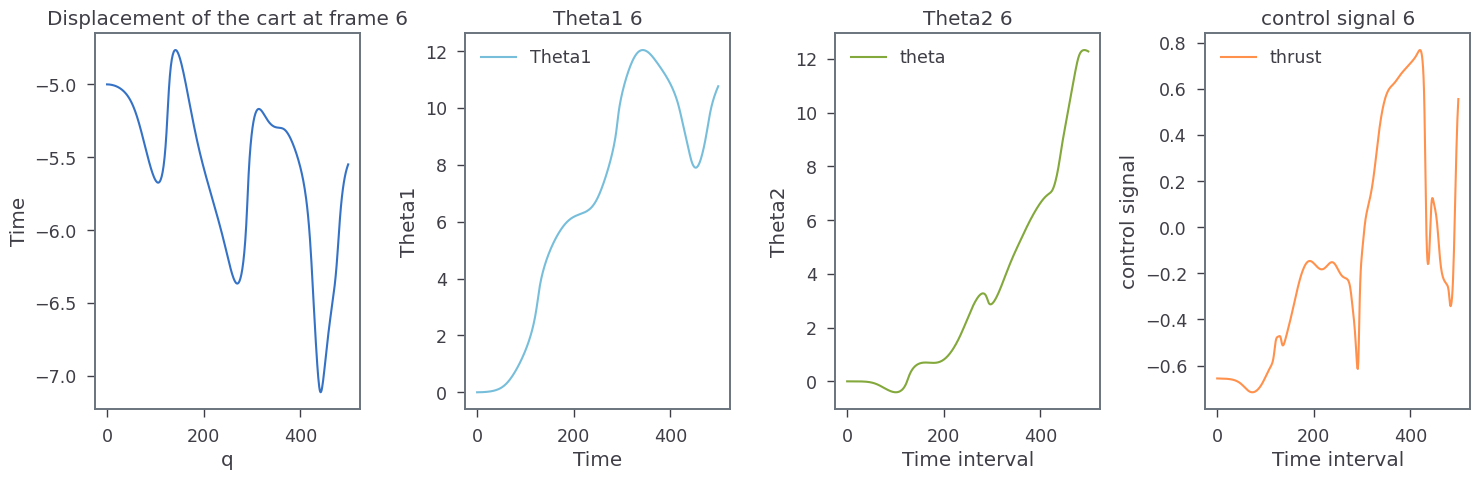

KeyboardInterrupt: ignored

In [ ]:
d = IDPDynamics()
c = controller()
s = Simulation(c, d)
o = Optimize(s)
o.train(50)
